**Veri Yükleme ve Ön İşlemler**

In [8]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Veri setini yükleme
file_path = 'veri-seti.txt'
column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", 
                "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
data = pd.read_csv(file_path, delimiter='\t', header=None, names=column_names)

# Eksik değerlerin yerini doldurma (0 değerlerini ortalama ile değiştirme)
data['Insulin'].replace(0, data['Insulin'].mean(), inplace=True)
data['SkinThickness'].replace(0, data['SkinThickness'].mean(), inplace=True)
data['Glucose'].replace(0, data['Glucose'].mean(), inplace=True)
data['BloodPressure'].replace(0, data['BloodPressure'].mean(), inplace=True)
data['BMI'].replace(0, data['BMI'].mean(), inplace=True)

# İlk birkaç satırı gözlemleyelim
print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
0            6    148.0           72.0      35.000000   79.799479  33.6   
1            1     85.0           66.0      29.000000   79.799479  26.6   
2            8    183.0           64.0      20.536458   79.799479  23.3   
3            1     89.0           66.0      23.000000   94.000000  28.1   
4            0    137.0           40.0      35.000000  168.000000  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


**Veriyi Eğitim ve Test Olarak Ayırma**

In [9]:
from sklearn.model_selection import train_test_split

# Veri setini özellikler ve hedef değişken olarak ayırma
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 537
Test set size: 231


**KNN Modeli ve En İyi K Değerini Belirleme**

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Veriyi ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# En iyi k değerini belirleme
k_values = range(1, 31)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_k = knn.predict(X_test_scaled)
    accuracies.append(accuracy_score(y_test, y_pred_k))

# En iyi k değeri
best_k = k_values[np.argmax(accuracies)]
print(f"Best k value: {best_k}")

# En iyi k değeri ile model eğitimi
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)

# Tahminleri elde etme
y_pred = knn_best.predict(X_test_scaled)
y_pred_prob = knn_best.predict_proba(X_test_scaled)[:, 1]  # ROC eğrisi için olasılık değerleri


Best k value: 13


**Performans Metriklerinin Hesaplanması**

Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81       151
           1       0.65      0.56      0.60        80

    accuracy                           0.74       231
   macro avg       0.72      0.70      0.71       231
weighted avg       0.74      0.74      0.74       231

Confusion Matrix:
 [[127  24]
 [ 35  45]]
ROC AUC: 0.80
Sensitivity: 0.56
Specificity: 0.84


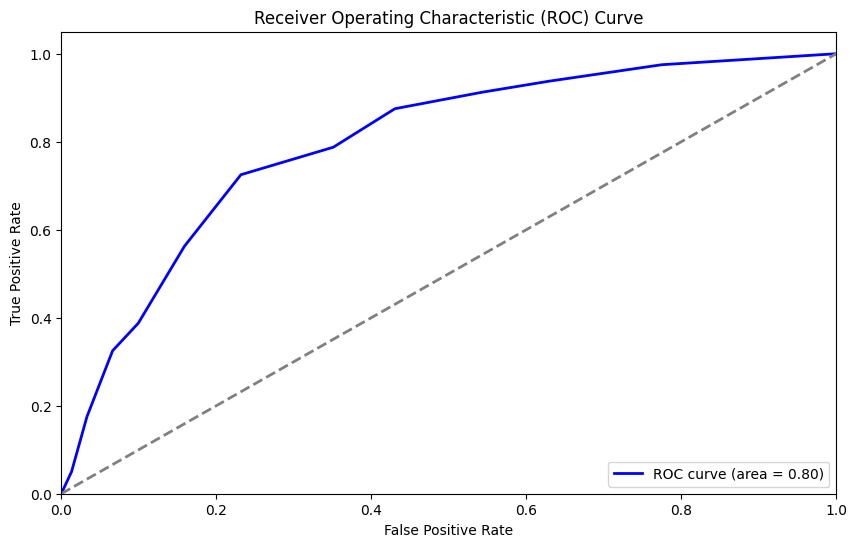

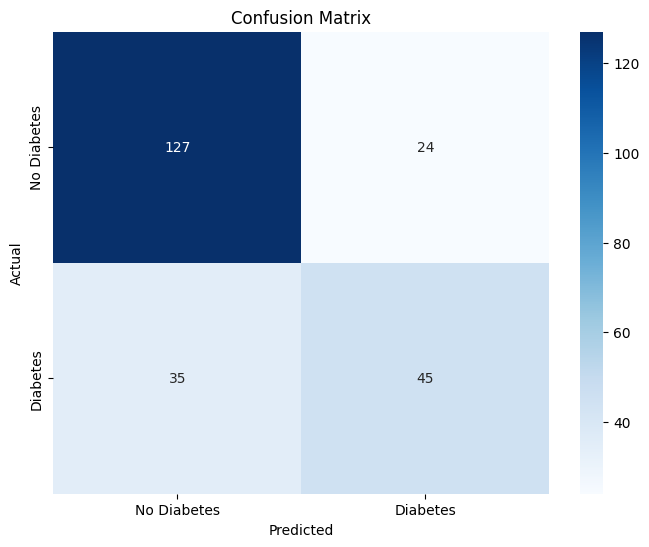

In [11]:
# Doğruluk
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Sınıflandırma Raporu
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Karışıklık Matrisi
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Eğrisi ve AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.2f}")

# Sensitivity (Recall) ve Specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# ROC Eğrisi Çizimi
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Karışıklık Matrisini Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
